In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
exp_data_path = '/content/drive/MyDrive/FYP_Data/FinalData/CleanedData.csv'
inter_data_path = '/content/drive/MyDrive/FYP_Data/FinalData/InterpolatedData.csv'

Loading Data

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU
from tensorflow.keras.models import Model
import numpy as np

from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

def tf_cast(x):
    return tf.cast(x, tf.float32)

In [4]:
exp_data = pd.read_csv(exp_data_path)
inter_data = pd.read_csv(inter_data_path)

print(exp_data.columns)
inter_data.head(5)

Index(['helical_angle', 'helical_layer_count', 'hoop_layer_count',
       'bust_pressure', 'tensile_str', 'e1_gpa', 'youngs_modulus',
       'poision_ratio', 'yeild_strength', 'ult_tensile_strength',
       'liner_thickness', 'diameter', 'doily_layers'],
      dtype='object')


,helical_angle,helical_layer_count,hoop_layer_count,tensile_str,e1_gpa,youngs_modulus,poision_ratio,yeild_strength,ult_tensile_strength,liner_thickness,diameter,doily_layers,bust_pressure
0,23.0,5.0,13.0,698.0,101.0,72.0,0.32,231.0,342.0,0.52,135.0,16.0,621.62
1,10.0,3.0,10.0,939.0,109.0,91.0,0.29,234.0,359.0,0.44,122.0,14.0,642.96
2,12.0,7.0,9.0,1045.0,95.0,62.0,0.32,250.0,348.0,0.46,142.0,9.0,650.75
3,11.0,15.0,9.0,987.0,105.0,124.0,0.29,232.0,368.0,0.50,133.0,25.0,649.61
4,14.0,14.0,12.0,853.0,107.0,85.0,0.30,243.0,361.0,0.51,126.0,21.0,637.21


In [5]:
input_cols = ['bust_pressure',  'tensile_str', 'e1_gpa', 'youngs_modulus', 'poision_ratio', 'yeild_strength', 'diameter', 'ult_tensile_strength']
output_cols = ['helical_angle', 'helical_layer_count', 'hoop_layer_count', 'liner_thickness', 'doily_layers']

In [6]:
exp_data_inp = exp_data[input_cols]
exp_data_out = exp_data[output_cols]
inter_data_inp = inter_data[input_cols]
inter_data_out = inter_data[output_cols]

In [7]:
x_train_exp, x_test_exp, y_train_exp, y_test_exp = train_test_split(exp_data_inp, exp_data_out, test_size=0.25, random_state=42)
x_train_inter, x_test_inter, y_train_inter, y_test_inter = train_test_split(inter_data_inp, inter_data_out, test_size=0.25, random_state=42)

x_val_exp, x_test_exp, y_val_exp, y_test_exp = train_test_split(x_test_exp, y_test_exp, train_size=0.6, random_state=49)
x_val_inter, x_test_inter, y_val_inter, y_test_inter = train_test_split(x_test_inter, y_test_inter, train_size=0.6, random_state=49)

In [8]:
x_train_exp.shape, x_val_exp.shape, x_test_exp.shape, x_train_inter.shape, x_val_inter.shape, x_test_inter.shape

((36, 8), (7, 8), (6, 8), (225, 8), (45, 8), (30, 8))

In [9]:
x_train = pd.concat([x_train_exp, x_train_inter], axis=0)
y_train = pd.concat([y_train_exp, y_train_inter], axis=0)
x_val = pd.concat([x_val_exp, x_val_inter], axis=0)
y_val = pd.concat([y_val_exp, y_val_inter], axis=0)
x_test = pd.concat([x_test_exp, x_test_inter], axis=0)
y_test = pd.concat([y_test_exp, y_test_inter], axis=0)

x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape, y_test.shape

((261, 8), (52, 8), (36, 8), (261, 5), (52, 5), (36, 5))

In [10]:
# Scaling - y
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_val_scaled = y_scaler.transform(y_val)
y_test_scaled = y_scaler.transform(y_test)

x_scaler = StandardScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
x_val_scaled = x_scaler.transform(x_val)
x_test_scaled = x_scaler.transform(x_test)

In [11]:
def inverse_scale(scaled_data, as_tensor=False, scaler=y_scaler):
    if as_tensor:
        # build tf constants matching the scaler
        scale = tf.constant(scaler.scale_, dtype=tf.float32)
        mean = tf.constant(scaler.mean_, dtype=tf.float32)
        # (batch_size, dims) * (dims,) + (dims,) → (batch_size, dims)
        return scaled_data * scale + mean
    else:
        # fallback to numpy inverse
        return scaler.inverse_transform(scaled_data)

## Making Model

Skipping the above steps = Redefing the models

In [12]:
input_dim = x_train.shape[1]
output_dim = y_train.shape[1]

input_dim, output_dim

(8, 5)

In [13]:
def build_model():
    input_layer = Input(shape=(input_dim,), name='input_layer')

    x = Dense(32, name='hidden_layer_1', activation='tanh')(input_layer)

    x = Dense(48, name='hidden_layer_2', activation='tanh')(x)

    x = Dense(24, name='hidden_layer_3', activation='tanh')(x)

    output_layer = Dense(output_dim, activation='linear', name='output_layer')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model

model = build_model()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_1 (Dense)          │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2 (Dense)          │ (None, 48)             │         1,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_3 (Dense)          │ (None, 24)             │         1,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 5)              │           125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,173 (12.39 KB)

 Trainable params: 3,173 (12.39 KB)

 Non-trainable params: 0 (0.00 B)

Defining Loss

In [14]:
# These are the assumed layer thicknesses used in the experiment
layer_thickness_hoop = tf.constant(0.2)
layer_thickness_helical = tf.constant(0.45)
layer_thickness_doily = tf.constant(0.5)

In [15]:
def physics_loss(x_input, y_pred):
    # Cast all inputs to float32 (or match your model's dtype)
    x_input = tf_cast(inverse_scale(x_input, as_tensor = True, scaler=x_scaler))
    y_pred = tf_cast(inverse_scale(y_pred, as_tensor = True))

    # Access features using indices
    diameter = x_input[:, input_cols.index('diameter')]
    liner_thickness = y_pred[:, output_cols.index('liner_thickness')]
    sigma_liner = x_input[:, input_cols.index('ult_tensile_strength')]
    n_hoop = y_pred[:, output_cols.index('hoop_layer_count')]
    sigma_cf = x_input[:, input_cols.index('tensile_str')]
    n_helical = y_pred[:, output_cols.index('helical_layer_count')]
    helical_angle = y_pred[:, output_cols.index('helical_angle')]
    n_doily = y_pred[:, output_cols.index('doily_layers')]
    input_brust_pressure = x_input[:, input_cols.index('bust_pressure')]


    liner_pressure = liner_thickness * sigma_liner
    hoop_pressure = layer_thickness_hoop * sigma_cf * n_hoop
    helical_pressure = layer_thickness_helical * sigma_cf * n_helical * (tf.cos(tf.cast(helical_angle * np.pi / 180.0, tf.float32)) ** 2)
    doily_pressure = layer_thickness_doily * sigma_cf * n_doily

    burst_pressure = 2 * (liner_pressure + hoop_pressure + helical_pressure + doily_pressure) / diameter

    loss = tf.reduce_mean(tf.abs(burst_pressure - input_brust_pressure))
    return loss

def data_loss(y_true, y_pred):
    # y_pred = inverse_scale(y_pred, as_tensor = True)
    # y_ture = inverse_scale(y_true, as_tensor = True)
    loss = tf.reduce_mean(tf.abs(y_true - y_pred))
    return loss

def loss_function(x_input, y_true, y_pred, physics_loss_factor=0.2):
    return data_loss(y_true, y_pred) + physics_loss_factor * physics_loss(x_input, y_pred)

In [16]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
epochs = 300
best_val_loss = float('inf')
batch_size = 8

In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_scaled, y_train_scaled)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val_scaled, y_val_scaled)).batch(batch_size)

In [18]:
def train_step(x_batch, y_batch):
    x_batch = tf.cast(x_batch, tf.float32)
    y_batch = tf.cast(y_batch, tf.float32)

    with tf.GradientTape() as tape:
        y_pred = model(x_batch, training=True)
        loss = loss_function(x_batch, y_batch, y_pred)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

def validate_step(x_batch, y_batch):
    x_batch = tf.cast(x_batch, tf.float32)
    y_batch = tf.cast(y_batch, tf.float32)

    y_pred = model(x_batch, training=False)
    return loss_function(x_batch, y_batch, y_pred)

In [19]:
def tf_r2score(y_true, y_pred):
    y_pred = inverse_scale(y_pred, as_tensor=True)
    y_true = inverse_scale(y_true, as_tensor=True)
    total_error = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    unexplained_error = tf.reduce_sum(tf.square(y_true - y_pred))
    return 1.0 - (unexplained_error / (total_error + 1e-7))

In [20]:
%%time

history = {
    'train_loss' : [],
    'val_loss' : [],
    'r2_score' : []
}
for epoch in range(epochs):
    # Training
    train_loss = []
    for x_batch, y_batch in train_dataset:
        loss = train_step(x_batch, y_batch)
        train_loss.append(loss)

    # Validation
    val_loss = []
    for x_batch, y_batch in val_dataset:
        loss = validate_step(x_batch, y_batch)
        val_loss.append(loss)

    # Calculate epoch metrics
    avg_train_loss = np.mean(train_loss)
    avg_val_loss = np.mean(val_loss)

    y_val_pred = model.predict(x_val_scaled)
    val_r2s = tf_r2score(y_val_scaled, y_val_pred).numpy()

    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['r2_score'].append(val_r2s)

    # Early stopping checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        model.save_weights("best_model.weights.h5")

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {avg_train_loss:.3f}, Val Loss: {avg_val_loss:.3f}, Val R2 Score: {val_r2s :.3f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Epoch 1/300
Train Loss: 97.626, Val Loss: 92.553, Val R2 Score: 0.374
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Epoch 2/300
Train Loss: 84.807, Val Loss: 76.326, Val R2 Score: -0.387
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Epoch 3/300
Train Loss: 62.868, Val Loss: 48.831, Val R2 Score: -2.906
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Epoch 4/300
Train Loss: 39.676, Val Loss: 29.837, Val R2 Score: -6.286
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Epoch 5/300
Train Loss: 31.694, Val Loss: 26.291, Val R2 Score: -7.399
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Epoch 6/300
Train Loss: 29.572, Val Loss: 24.739, Val R2 Score: -7.497
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Epoch 7/300
Train Loss: 27.256, Val Loss: 21.622, Val R2 Score: -7.494
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Epoch 8/300
Train Loss: 22.549, Val Loss: 17.588, Val R2 Score: -7.809
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Epoch 9/300
Train Loss: 18.150, Val Loss: 14.273, Val R2 Score: -8.545
2/2 ━━━━━━━━━━━━━━━━

In [21]:
import joblib

# Export the scalers to files
joblib.dump(x_scaler, 'x_scaler.pkl')
joblib.dump(y_scaler, 'y_scaler.pkl')

joblib.dump(model, 'final_model.pkl')

['final_model.pkl']

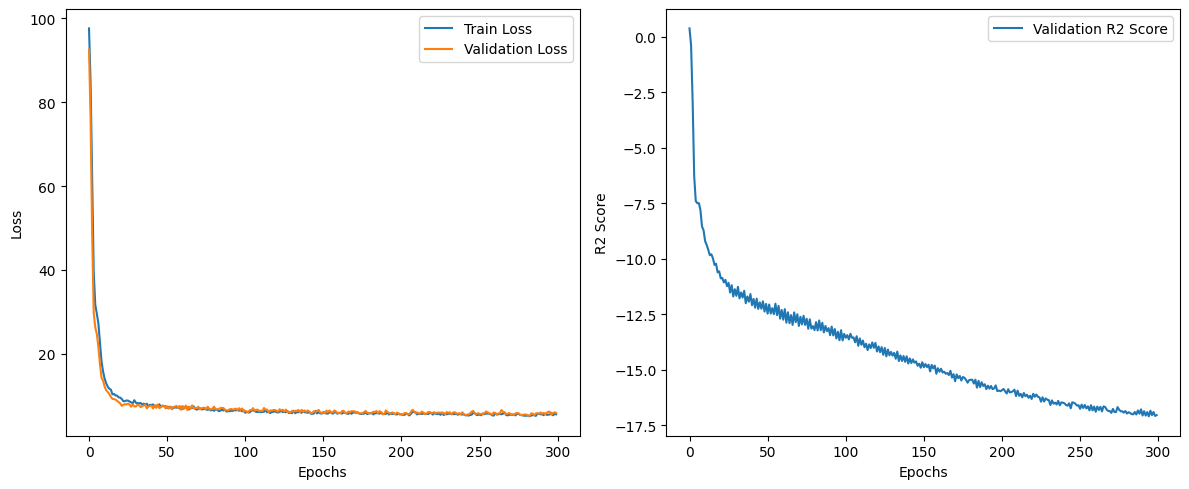

In [22]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history['r2_score'], label='Validation R2 Score')
plt.xlabel('Epochs')
plt.ylabel('R2 Score')
plt.legend()

plt.tight_layout()
plt.show()

Predicting the test values

In [32]:
y_test_pred = model.predict(x_test_scaled)
y_test_pred = inverse_scale(y_test_pred, as_tensor=True)
pd.DataFrame(y_test_pred, columns = output_cols).tail()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


,helical_angle,helical_layer_count,hoop_layer_count,liner_thickness,doily_layers
31,18.051270,8.135119,9.512460,0.393508,72.190361
32,16.976032,16.013250,9.566317,0.981600,96.204689
33,17.768900,14.261793,9.511033,0.769419,90.152763
34,18.067940,8.807643,9.791492,0.443575,74.513847
35,18.144012,8.861890,9.702462,0.458639,74.510834


In [33]:
pd.DataFrame(y_test, columns = output_cols).tail()

,helical_angle,helical_layer_count,hoop_layer_count,liner_thickness,doily_layers
77,27.0,9.0,12.0,0.43,16.0
239,26.0,12.0,8.0,0.55,15.0
250,29.0,8.0,12.0,0.56,8.0
126,21.0,7.0,13.0,0.42,9.0
42,20.0,9.0,4.0,0.47,15.0


There is huge difference in the Results